In [1]:
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

# Prediction Models by Comorbidities
In this notebook we build different models to predict the 30-day readmission rate by the 29 comorbidity categories. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from DL_utils import plot_roc
from sklearn.metrics import roc_curve, auc
import statsmodels.stats.api as sms

In [4]:
%matplotlib inline

In [4]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from ccs_tools import core_dtypes_pd

## Data reading and splitting
We first read the ami index cohort, select only the first admission of each patient, and do a train-test splitting. 

In [7]:
cohort = 'ami'
n_fold = 10

In [6]:
data_df = pd.read_csv(path+'cohorts/{}/{}_pred.csv'.format(cohort, cohort), dtype=core_dtypes_pd)

In [8]:
for fold_ind in range(n_fold):
    tst_key = pd.read_csv(path+'cohorts/{}/tst_key{}.csv'.format(cohort, fold_ind), names=['KEY_NRD'])
    tst_df = data_df.loc[data_df.KEY_NRD.isin(tst_key.KEY_NRD)]
    train_df = data_df.loc[~data_df.KEY_NRD.isin(tst_key.KEY_NRD)]
    train_df.to_csv(path+'cohorts/{}/comorb_train{}.csv'.format(cohort, fold_ind), index=False)
    tst_df.to_csv(path+'cohorts/{}/comorb_tst{}.csv'.format(cohort, fold_ind), index=False)

## Mixed Effects Logistic Regression
This part is done by the R package lme4, in a separate notebook "Mixed_effect_logistic.ipynb". Here we directly read the result: prediction scores and the true outcomes for the test set.

In [17]:
pred_test = pd.read_csv(path+'cohorts/chf/prediction_MELR0.csv')

In [28]:
n_fold = 10
auc_lst = []
for fold_ind in range(n_fold):
    pred_test = pd.read_csv(path+'cohorts/chf/prediction_MELR'+str(fold_ind)+'.csv')
    fpr, tpr, _ = roc_curve(pred_test['y_true'].values, pred_test['y_pred'].values)
    auc_lst.append(auc(fpr, tpr))

In [21]:
np.mean(auc_lst)

0.5898464506724922

In [30]:
np.std(auc_lst)

0.0017206897652525062

In [29]:
print('{0:.4f}'.format(np.mean(auc_lst)))
print('({0:.4f}, {1:.4f})'.format(*sms.DescrStatsW(auc_lst).tconfint_mean()))

0.5898
(0.5885, 0.5911)


In [ ]:
sms.DescrStatsW(auc_lst)

### Result visualization

In [16]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [19]:
fpr, tpr, _ = roc_curve(pred_test['y_true'].values, pred_test['y_pred'].values)
auc(fpr, tpr)

0.6806022149893868

{0: 0.6770002708238051}

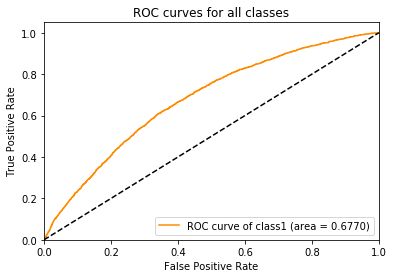

In [42]:
plot_roc(pred_test['y_pred'].values, pred_test['y_true'].values)

## Fully Connected Neural Nets

### Prepare the training data

In [19]:
df = pd.read_csv(path+'cohorts/ami/comorb_train.csv')

In [20]:
comorb = ['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS',
       'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX',
       'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES',
       'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH',
       'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE',
       'CM_WGHTLOSS']

In [21]:
trn_df, val_df = train_test_split(df, test_size=0.11, random_state=24, stratify = df['HOSP_NRD'])

In [22]:
N_trn = len(trn_df)
N_val = len(val_df)

In [23]:
X_trn = trn_df[['AGE', 'FEMALE']+comorb].values
X_val = val_df[['AGE', 'FEMALE']+comorb].values

mean_age = trn_df['AGE'].mean()
sigma_age = trn_df['AGE'].std()
X_trn[:, 0] = (X_trn[:, 0] - mean_age)/sigma_age
X_val[:, 0] = (X_val[:, 0] - mean_age)/sigma_age

In [24]:
mean_age, sigma_age

(66.17134972231185, 13.808092896091805)

In [24]:
hosp_series = pd.concat([trn_df, val_df])['HOSP_NRD']
hosp_series = hosp_series.astype(int).astype('category')

old_cat = hosp_series.cat.categories
n_cat = len(old_cat)

hosp_series = hosp_series.cat.rename_categories(range(n_cat))
hosp_array = hosp_series.astype(int).values

hosp_trn = hosp_array[:N_trn]
hosp_val = hosp_array[N_trn:]

In [25]:
y_trn = trn_df['readm30'].values.astype(int)
y_val = val_df['readm30'].values.astype(int)

In [26]:
X_trn.shape, hosp_trn.shape, y_trn.shape, X_val.shape, hosp_val.shape, y_val.shape

((145667, 31), (145667,), (145667,), (18004, 31), (18004,), (18004,))

In [33]:
X_trn.dtype, hosp_trn.dtype, y_trn.dtype

(dtype('float64'), dtype('int64'), dtype('int64'))

### Model building

In [27]:
from keras.layers import Input, Embedding, concatenate, Reshape, BatchNormalization
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


In [30]:
from importlib import reload
import keras_addon
reload(keras_addon)

<module 'keras_addon' from '/home/wsliu/Codes/DLproj/keras_addon.py'>

In [31]:
from keras_addon import AUCCheckPoint

In [32]:
Y_trn = to_categorical(y_trn)
Y_val = to_categorical(y_val)

In [48]:
input_X = Input(shape=(31,))

embed_dim = 2
input_hosp = Input(shape=(1,))
embed_out = Embedding(n_cat, embed_dim, input_length=1)(input_hosp)
embed_out = Reshape((embed_dim,))(embed_out)

merged_X = concatenate([input_X, embed_out], axis=1)

x = Dense(64, activation='relu')(merged_X)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
#x = Dense(16, activation='relu')(x)

prediction = Dense(2, activation='softmax', name='readm')(x)
model = Model(inputs=[input_X, input_hosp], outputs=prediction)

In [49]:
adam = Adam(0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
checkpointer = ModelCheckpoint(filepath=model_path+'ami_comorb_valloss1.h5', verbose=0, save_best_only=True, save_weights_only=True)
auc_checkpoint = AUCCheckPoint(model_path+'ami_comorb_auc1.h5', validation_y=y_val, validation_x=[X_val, hosp_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=15)

In [36]:
class_weight = {0:(len(y_trn)/sum(Y_trn[:,0])), 1:(len(y_trn)/sum(Y_trn[:,1]))}

In [51]:
hist = model.fit([X_trn, hosp_trn], Y_trn, batch_size=512, epochs=20, callbacks=[checkpointer, auc_checkpoint, reduce_lr, earlystop],
                 validation_data=[[X_val, hosp_val], Y_val], class_weight = class_weight, verbose=1)

Train on 145667 samples, validate on 18004 samples
Epoch 1/20
145667/145667 [==============================] - 2s 10us/step - loss: 1.3288 - acc: 0.5807 - val_loss: 0.6443 - val_acc: 0.5963
AUC: 0.6804

Epoch 2/20
145667/145667 [==============================] - 1s 8us/step - loss: 1.2924 - acc: 0.5990 - val_loss: 0.6064 - val_acc: 0.6288
AUC: 0.6847

Epoch 3/20
145667/145667 [==============================] - 1s 7us/step - loss: 1.2807 - acc: 0.5944 - val_loss: 0.6196 - val_acc: 0.6130
AUC: 0.6844

Epoch 4/20
145667/145667 [==============================] - 1s 7us/step - loss: 1.2735 - acc: 0.5911 - val_loss: 0.6318 - val_acc: 0.5900
AUC: 0.6839

Epoch 5/20
145667/145667 [==============================] - 1s 7us/step - loss: 1.2718 - acc: 0.5833 - val_loss: 0.6544 - val_acc: 0.5751
AUC: 0.6839

Epoch 6/20
145667/145667 [==============================] - 1s 7us/step - loss: 1.2708 - acc: 0.5874 - val_loss: 0.6231 - val_acc: 0.5918
AUC: 0.6823

Epoch 7/20
145667/145667 [================

### Model Testing

In [41]:
from DL_utils import plot_roc

In [52]:
tst_df = pd.read_csv(path+'cohorts/ami/comorb_tst.csv')

In [53]:
X_tst = tst_df[['AGE', 'FEMALE']+comorb].values
X_tst[:, 0] = (X_tst[:, 0] - mean_age)/sigma_age

hosp_tst_series = tst_df['HOSP_NRD'].astype(int).astype('category')

hosp_tst_series = hosp_tst_series.cat.rename_categories(range(n_cat))
hosp_tst = hosp_tst_series.astype(int).values

In [60]:
model.load_weights(model_path+'ami_comorb_valloss1.h5')

In [61]:
y_pred = model.predict([X_tst, hosp_tst], batch_size=512, verbose=1)

18186/18186 [==============================] - 0s 2us/step


In [62]:
y_pred = y_pred[:,1]

In [63]:
y_true = tst_df['readm30'].values

In [58]:
y_pred.shape, y_true.shape

((18186,), (18186,))

{0: 0.6784096906395523}

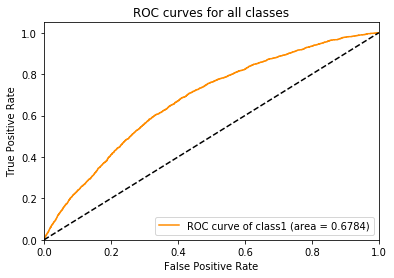

In [64]:
plot_roc(y_pred, y_true)